In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from urllib.parse import urlencode
from urllib.request import Request, urlopen
import json
import numpy as np
import pandas as pd

In [ ]:
api_url = 'http://localhost:8080/fakebox/check' # Set destination URL here

In [ ]:
def get_json_str(title, content=None, url=None):
    if content and url:
        post_fields = {'title': title, 'content': content, 'url': url}     # Set POST fields here
    elif content:
        post_fields = {'title': title, 'content': content}     # Set POST fields here
    else:
        post_fields = {'title': title}
    request = Request(api_url, urlencode(post_fields).encode())
    json_str = urlopen(request).read().decode()
    return json_str

In [ ]:
def parse_json_str(json_str, content=None, url=None):
    json_data = json.loads(json_str)
    title_fake_score = json_data['title']['score']
    title_pred_type = json_data['title']['decision']
    if content:
        content_fake_score = json_data['content']['score']
        content_pred_type = json_data['content']['decision']
    else:
        content_fake_score = 0
        content_pred_type = 0
    if url:
        domain_type = json_data['domain']['category']
    else:
        domain_type = None
    return title_fake_score, title_pred_type, content_fake_score, content_pred_type, domain_type

In [ ]:
df = pd.read_csv('data/filtered_fake.csv', index_col='uuid', dtype = {'title': str, 'text': str, 'main_img_url': str, 'site_url': str})

In [ ]:
all_title_fake_score = []
all_title_pred_type = []
all_content_fake_score = []
all_content_pred_type = []
all_domain_type = []
i = 0
for index, row in df.iterrows():
    title = row['title']
    content = row['text'][:10000]
    url = row['main_img_url']
    # content = None
    json_str = get_json_str(title, content, url)
    title_fake_score, title_pred_type, content_fake_score, content_pred_type, domain_type = parse_json_str(json_str, content, url)
    all_title_fake_score.append(title_fake_score)
    all_title_pred_type.append(title_pred_type)
    all_content_fake_score.append(content_fake_score)
    all_content_pred_type.append(content_pred_type)
    all_domain_type.append(domain_type)
    i += 1
    if i%100 == 0:
        print("Iteration = ", i)

In [ ]:
df['title_fake_score'] = all_title_fake_score
df['title_pred_type'] = all_title_pred_type
df['content_fake_score'] = all_content_fake_score
df['content_pred_type'] = all_content_pred_type
df['domain_type'] = all_domain_type

In [ ]:
df.to_csv('data/filtered_fake_labelled.csv')

## Validation

In [ ]:
test_df = pd.read_csv('data/real_or_fake.csv', dtype = {'title': str, 'text': str})

In [ ]:
len(test_df)

In [ ]:
test_df.head(5)

In [ ]:
test_df = test_df[:3000]

In [ ]:
all_title_fake_score = []
all_title_pred_type = []
all_content_fake_score = []
all_content_pred_type = []
i = 0
for index, row in test_df.iterrows():
    content = row['text'][:10000]
    # content = None
    json_str = get_json_str(row['title'], content)
    title_fake_score, title_pred_type, content_fake_score, content_pred_type = parse_json_str(json_str, content)
    all_title_fake_score.append(title_fake_score)
    all_title_pred_type.append(title_pred_type)
    all_content_fake_score.append(content_fake_score)
    all_content_pred_type.append(content_pred_type)
    i += 1
    if i%1000 == 0:
        print("Iteration = ", i)

In [ ]:
test_df['title_fake_score'] = all_title_fake_score
test_df['title_pred_type'] = all_title_pred_type
test_df['content_fake_score'] = all_content_fake_score
test_df['content_pred_type'] = all_content_pred_type

In [ ]:
test_df.to_csv('data/real_or_fake_labelled.csv')

In [ ]:
test_df

In [ ]:
df['type'].value_counts().plot(kind='bar')

In [ ]:
X = np.zeros((len(test_df),2))
X[:,0] = test_df['title_fake_score'].values
X[:,1] = test_df['content_fake_score'].values

In [ ]:
y = np.zeros((len(test_df),))
for i, label in enumerate(test_df['label']):
    if label == 'FAKE':
        y[i] = 1
    else:
        y[i] = -1

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
clf = SVC()
clf.fit(X, y)

In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(clf, X, y, cv=10)
print("10 fold cv score = {}".format(np.average(cv_scores)))

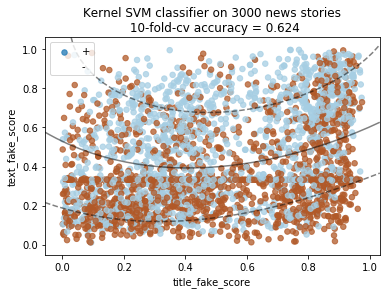

In [243]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired, alpha=0.75)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none')
plt.xlabel('title_fake_score')
plt.ylabel('text_fake_score')
plt.title('Kernel SVM classifier on {} news stories\n 10-fold-cv accuracy = {:.3f}'.format(X.shape[0], np.average(cv_scores)))
plt.show()

In [231]:
mask = np.where(y==1)
X[mask,:]

array([[[0.36188692, 0.19542237],
        [0.05175699, 0.69031423],
        [0.0335523 , 0.60731322],
        ...,
        [0.41213202, 0.33232278],
        [0.83175635, 0.52058512],
        [0.30146611, 0.07178909]]])